In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Reshape, Multiply, Add, Concatenate, Lambda
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [19]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [20]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [21]:
def load_dataset_group(group, base_path=''):
    filepath = base_path + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(base_path + group + '/y_'+group+'.txt')
    return X, y

In [22]:
def load_dataset(base_path=''):
    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [23]:
BASE_PATH = '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/'

In [24]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(BASE_PATH)

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [25]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
print(f"입력 형태: (타임스텝={n_timesteps}, 특성={n_features}), 출력 클래스={n_outputs}")

입력 형태: (타임스텝=128, 특성=9), 출력 클래스=6


In [26]:
def cbam_block(input_tensor, ratio=8):
    channel = int(input_tensor.shape[-1])

    # ----- Channel Attention -----
    avg_pool = GlobalAveragePooling1D()(input_tensor)
    max_pool = GlobalMaxPooling1D()(input_tensor)
    dense1 = Dense(channel // ratio, activation='relu')
    dense2 = Dense(channel, activation='sigmoid')
    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Reshape((1, channel))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    # ----- Spatial Attention (Lambda 레이어로 수정) -----
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv1D(1, 3, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])
    return x

In [27]:
def inception_module(input_tensor, filters=32):
    conv1 = Conv1D(filters, 1, padding='same', activation='relu')(input_tensor)
    conv3 = Conv1D(filters, 3, padding='same', activation='relu')(input_tensor)
    conv5 = Conv1D(filters, 5, padding='same', activation='relu')(input_tensor)
    conv7 = Conv1D(filters, 7, padding='same', activation='relu')(input_tensor)
    output = Concatenate(axis=-1)([conv1, conv3, conv5, conv7])
    return output

In [28]:
inputs = Input(shape=(n_timesteps, n_features))

x = inception_module(inputs, filters=32)
x = cbam_block(x)
x = MaxPooling1D(pool_size=2)(x)

x = inception_module(x, filters=64)
x = cbam_block(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

inception_cbam_model = Model(inputs, outputs)
inception_cbam_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
inception_cbam_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 128, 32)   │        320 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 128, 32)   │        896 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 128, 32)   │      1,472 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 128, 32)   │      2,048 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 128, 128)  │          0 │ conv1d_36[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_37[0][0],  │
│                     │                   │            │ conv1d_38[0][0],  │
│                     │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ concatenate_12[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ concatenate_12[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 16)        │      2,064 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │      2,176 │ dense_20[0][0],   │
│                     │                   │            │ dense_20[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128)       │          0 │ dense_21[0][0],   │
│                     │                   │            │ dense_21[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1, 128)    │          0 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 128, 128)  │          0 │ concatenate_12[0… │
│ (Multiply)          │                   │            │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128, 2)    │          0 │ lambda_8[0][0],   │
│ (Concatenate)       │                   │            │ lambda_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 128, 1)    │          7 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 128, 128)  │          0 │ multiply_12[0][0… │
│ (Multiply)          │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 64, 128)   │          0 │ multiply_13[0][0

 Total params: 4,354,884 (16.61 MB)

 Trainable params: 4,354,884 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_history = inception_cbam_model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.7392 - loss: 0.6065 - val_accuracy: 0.9252 - val_loss: 0.1569
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.9468 - loss: 0.1289 - val_accuracy: 0.9497 - val_loss: 0.1184
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.9570 - loss: 0.1072 - val_accuracy: 0.9524 - val_loss: 0.1099
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.9543 - loss: 0.1051 - val_accuracy: 0.9538 - val_loss: 0.1051
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.9560 - loss: 0.0979 - val_accuracy: 0.9463 - val_loss: 0.1230
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.9558 - loss: 0.1007 - val_accuracy: 0.9572 - val_loss: 0.1076
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.9623 - loss: 0.0976 - val_accuracy: 0.9449 - val_loss: 0.1369
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.9553 - loss: 0

In [30]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

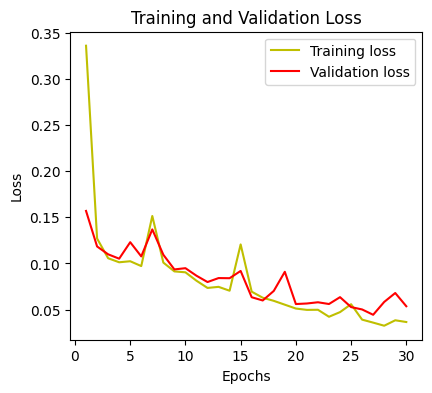

In [31]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

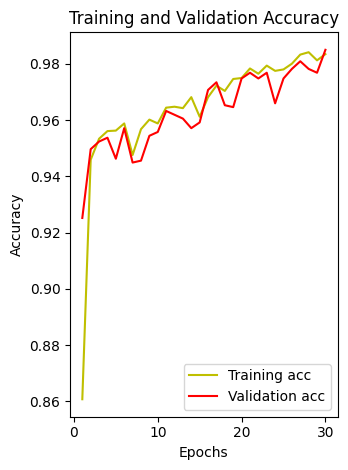

In [32]:
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

=== Confusion Matrix ===
[[480   3  12   0   1   0]
 [  6 441  22   2   0   0]
 [  4   2 414   0   0   0]
 [  0   3   0 396  86   6]
 [  0   1   0  68 463   0]
 [  0   3   0   0   0 534]]

Accuracy: 0.9256871394638616

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       496
           1       0.97      0.94      0.95       471
           2       0.92      0.99      0.95       420
           3       0.85      0.81      0.83       491
           4       0.84      0.87      0.86       532
           5       0.99      0.99      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



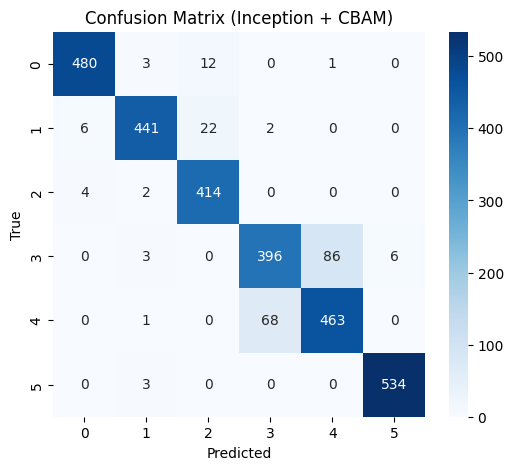

In [33]:
pred = inception_cbam_model.predict(testX)
pred_classes = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred_classes)

print("\n=== Confusion Matrix ===")
print(cm)
print("\nAccuracy:", accuracy_score(testy, pred_classes))
print("\n=== Classification Report ===")
print(classification_report(testy, pred_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Inception + CBAM)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()